In [ ]:
import os
import urllib.request
import regex as re
import tqdm

import bolift
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import shap
import scipy as sp
import scipy.cluster
# from xgboost import XGBRegressor


seed = 2023
np.random.seed(seed)

In [64]:

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# bolift

In [8]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env")

False

### Setting Environment

In [2]:
os.environ['OPENAI_API_KEY']='<YOURE API KEY HERE>'

## Some Util Functions to work with the experimental descriptions

In [6]:
#first part, given an the features, make the prompt
def make_prompt_from_features(features):    
    prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                        "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                        "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                        "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                        "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                        "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."
    #check if features are as dataframe, change to kwargs
    if isinstance(features, np.ndarray):
        features = features.tolist()
        return prompt_template.format(**features)
    features = features.to_dict()
    return prompt_template.format(**features)


In [4]:

def extract_parameters(text):
    params = {}
    # Dimension1(nm)
    match = re.search(r'dimensions (\S+) nm by', text)
    params['Dimension1(nm)'] = match.group(1) if match else None

    # Dimension2(nm)
    match = re.search(r'by (\S+) nm and the optical density', text)
    params['Dimension2(nm)'] = match.group(1) if match else None

    # Dilution(%)
    match = re.search(r'optical density of 100x hexanes dilution of stock is (\S+)% recorded at', text)
    params['Dilution(%)'] = match.group(1) if match else None

    # Nano_stock_vol(mL)
    match = re.search(r'(\S+) mL nanoplatelets stock is diluted', text)
    params['Nano_stock_vol(mL)'] = match.group(1) if match else None

    # Diluted_vol(mL)
    match = re.search(r'using (\S+) mL for each trial', text)
    params['Diluted_vol(mL)'] = match.group(1) if match else None

    # AgConc(M)
    match = re.search(r'Silver acetate solution of (\S+) M is made', text)
    params['AgConc(M)'] = match.group(1) if match else None

    # AgMass(mg)
    match = re.search(r'with (\S+) mg of silver acetate in', text)
    params['AgMass(mg)'] = match.group(1) if match else None

    # MeOH_vol(mL)
    match = re.search(r'in (\S+) mL of MeOH and', text)
    params['MeOH_vol(mL)'] = match.group(1) if match else None

    # H2O_vol(mL)
    match = re.search(r'and (\S+) mL of water', text)
    params['H2O_vol(mL)'] = match.group(1) if match else None

    # Doping(%)
    match = re.search(r'(\S+) % Ag doping requires', text)
    params['Doping(%)'] = match.group(1) if match else None

    # AgSol(uL)
    match = re.search(r'requires (\S+) uL of silver doping solution', text)
    params['AgSol(uL)'] = match.group(1) if match else None

    # Time(min)
    match = re.search(r'for (\S+) minutes at', text)
    params['Time(min)'] = match.group(1) if match else None

    # Temperature(C)
    match = re.search(r'at (\S+) oC', text)
    params['Temperature(C)'] = match.group(1) if match else None

    return params


In [5]:
df = pd.read_csv('/Users/jorgemedina/DOEFinal/DOE/procedures.tsv', sep='\t')
texts = df['prompt'].tolist()

# Collect all parameter dictionaries
data = [extract_parameters(t) for t in texts]

# Create a DataFrame
df_2 = pd.DataFrame(data)
print(df_2)
#add the "obj_f" column to the dataframe
df_2['obj_f'] = df['obj_f']

   Dimension1(nm) Dimension2(nm) Dilution(%) Nano_stock_vol(mL)  \
0            18.8          14.04       0.175               0.25   
1            18.8          14.04       0.175               0.25   
2            18.8          14.04       0.175               0.25   
3            18.8          14.04       0.175               0.25   
4            18.8          14.04       0.175               0.25   
5            18.8          14.04       0.175               0.25   
6            18.8          14.04       0.175               0.25   
7            18.8          14.04       0.175               0.25   
8            18.8          14.04       0.175               0.25   
9            18.8          14.04       0.175               0.25   
10           18.8          14.04       0.175               0.25   
11           18.8          14.04       0.175               0.25   
12           18.8          14.04       0.175               0.25   
13           35.0           15.0       0.212                0.

### Get data features

In [87]:
X = df_2.drop('obj_f', axis=1)
X
#change the values from strings to float
X = X.astype(float)

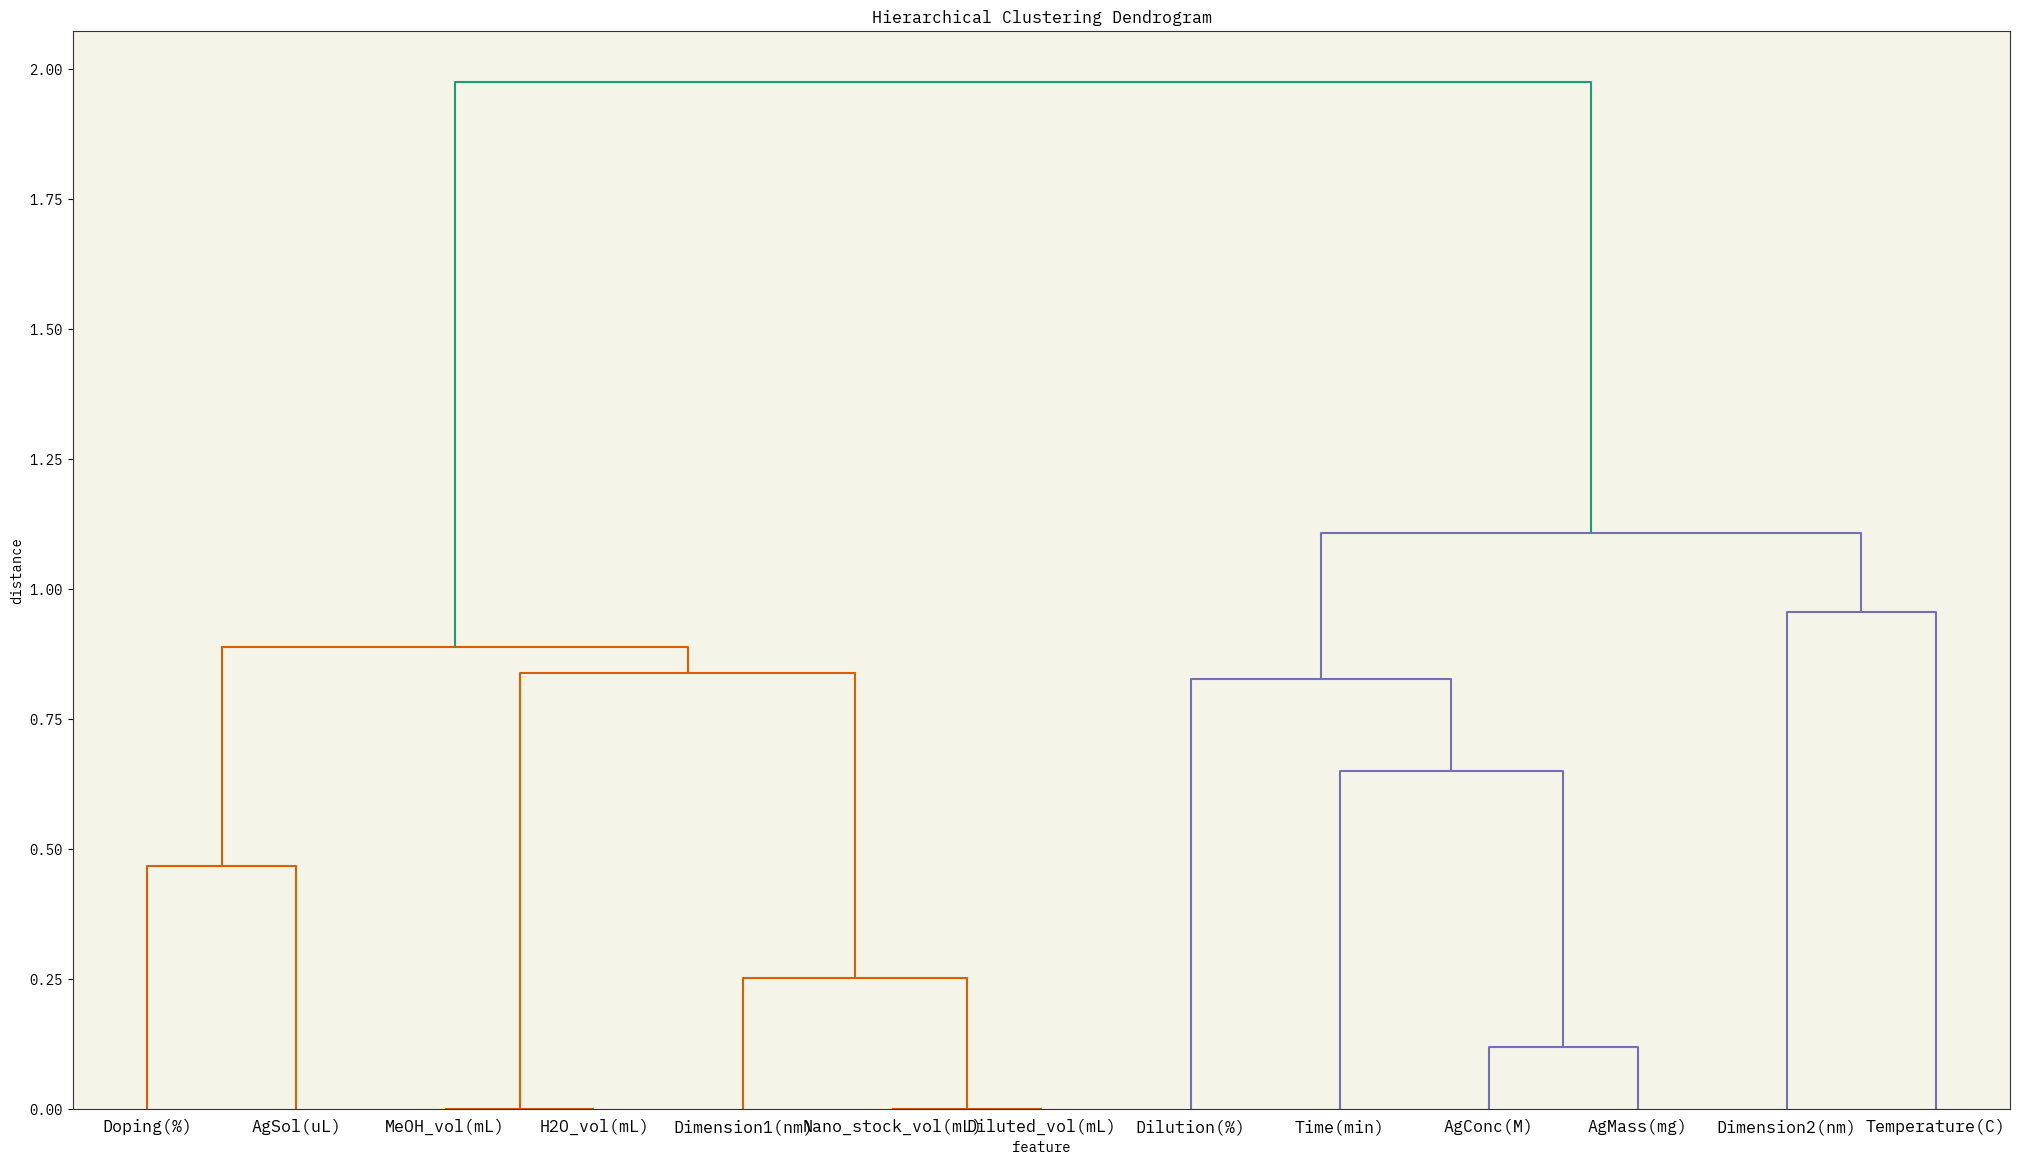

In [91]:
## Following the example from shap documentation: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20California%20Demo.html

partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(25, 14))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")

plt.show()

In [93]:
feature_names = df_2.keys()[:-1]
feature_names


Index(['Dimension1(nm)', 'Dimension2(nm)', 'Dilution(%)', 'Nano_stock_vol(mL)',
       'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)', 'MeOH_vol(mL)',
       'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)', 'Temperature(C)'],
      dtype='object')

### Training our BOLIFT Model

In [134]:
X = df_2.drop('obj_f', axis=1)

In [221]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo-instruct",
    selector_k=5,
    temperature=0.7
)
labels_f = df_2['obj_f'].to_list()
for i,l in enumerate(labels_f):
  p = make_prompt_from_features(df_2.iloc[i].drop('obj_f'))
  if i <3: 
    print(p)
  asktell.tell(p, float(l))
  

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 1.25 % Ag doping requires 1.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60 minutes at 25 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5 mL of MeOH and 2 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was perf

In [ ]:
#defining a wrapper of our BOLIFT model that: 1) takes a dataframe as input, 2) converts it into a text prompt, 3) queries the BOLIFT model, and 4) returns the model's prediction
def f(x):
    results = []
    for i in range(len(x)):
        # Determine if x is a DataFrame or NumPy array
        if isinstance(x, pd.DataFrame):
            features = x.iloc[i]
        else:
            # x is a NumPy array; create a Series with proper feature names
            features = pd.Series(x[i], index=feature_names)
        
        prompt = make_prompt_from_features(features)
        #with a probability of 0.05 print the prompt, to check if the prompt is being generated correctly
        if np.random.rand() < 0.05:
            print(prompt)
        results.append(asktell.predict(prompt).mean())
    return np.array(results)

In [224]:
## Testing the function predicts one value.
f(df_2.iloc[[1]].drop('obj_f', axis=1))

array([0.23])

In [212]:
masker = shap.maskers.Partition(X, clustering=partition_tree)
masker_explainer = shap.PartitionExplainer(f, masker)

In [233]:
lowmid_shap_val = masker_explainer(X[6:7]) 

Stock nanoplatelets have dimensions 35.0 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 5.0 % Ag doping requires 230.57 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The rea

  0%|          | 0/156 [00:00<?, ?it/s]

Stock nanoplatelets have dimensions 35.0 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reacti

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.25 % Ag doping requires 3.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.5 % Ag doping requires 6.0 uL of silver doping solution, respectively. The r

  8%|▊         | 12/156 [14:53<2:58:43, 74.47s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 9.0 uL of silver doping solution, respectively. The rea

 14%|█▍        | 22/156 [25:24<2:32:33, 68.31s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reac

 21%|██        | 32/156 [31:01<1:49:51, 53.16s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The 

 27%|██▋       | 42/156 [34:16<1:16:23, 40.21s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 10.0 % Ag doping requires 13.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.5 % Ag doping requires 18.0 uL of silver doping solution, respectively. The r

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 35.0 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 5.0 % Ag doping requires 230.57 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 46.3494 nm by 8.095 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 14.0 mg of silver acetate in 10.0 mL of MeOH and 4.0 mL of water. 5.0 % Ag doping requires 45.3 uL of silver doping solution, respectively. The

 33%|███▎      | 52/156 [49:11<1:40:00, 57.70s/it]

Stock nanoplatelets have dimensions 29.529 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 5.0 % Ag doping requires 6.8 uL of silver doping solution, respectively. The rea

 40%|███▉      | 62/156 [52:57<1:11:53, 45.89s/it]

Stock nanoplatelets have dimensions 35.0 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.0 % Ag doping requires 92.22 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 35.0 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 5.0 % Ag doping requires 230.57 uL of silver doping solution, respectively. The r

 46%|████▌     | 72/156 [56:59<54:23, 38.86s/it]  

Stock nanoplatelets have dimensions 35.0 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 138.33 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. Th

 53%|█████▎    | 82/156 [1:00:37<41:17, 33.47s/it]

Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 31.63 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The re

 59%|█████▉    | 92/156 [1:05:35<34:28, 32.31s/it]

Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.


Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respec

 65%|██████▌   | 102/156 [1:19:13<42:47, 47.55s/it]

Stock nanoplatelets have dimensions 36.27 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. Th

 72%|███████▏  | 112/156 [1:24:06<30:47, 41.99s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The 

 78%|███████▊  | 122/156 [1:30:26<23:06, 40.77s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The rea

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The re

 85%|████████▍ | 132/156 [1:44:48<21:48, 54.51s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 14.0 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The

 91%|█████████ | 142/156 [1:47:44<10:07, 43.39s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 5.0 % Ag doping requires 6.8 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.5 % Ag doping requires 18.0 uL of silver doping solution, respectively. The rea

 97%|█████████▋| 152/156 [1:50:48<02:23, 35.86s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.25 % Ag doping requires 15.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 31.63 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 14.0 mg of silver acetate in 10.0 mL of MeOH and 4.0 mL of water. 0.5 % Ag doping requires 1.5 uL of silver doping solution, respectively. The r

PartitionExplainer explainer: 2it [1:54:11, 6851.46s/it]           


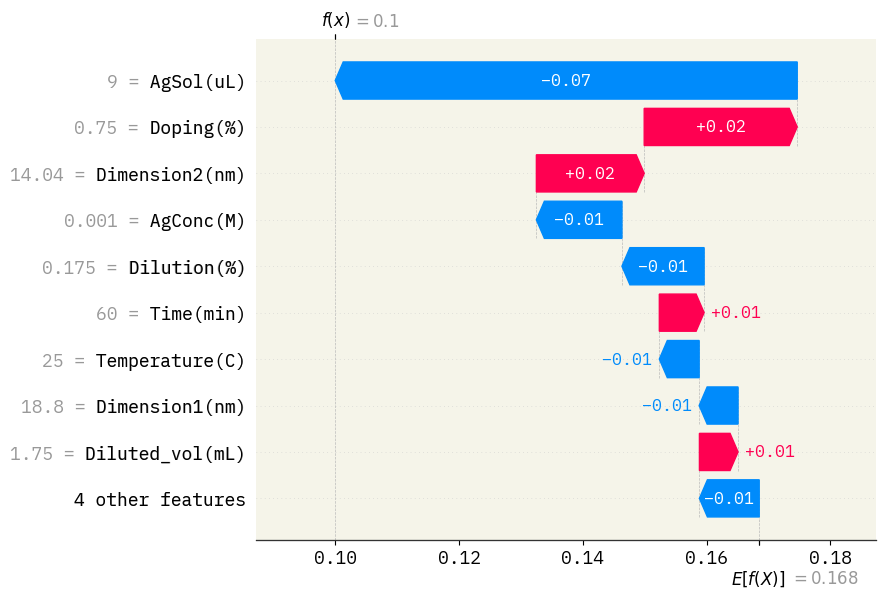

In [234]:
shap.plots.waterfall(lowmid_shap_val[0])

In [239]:
low_shap_val = masker_explainer(X[34:35]) 

Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10.0 mL of MeOH and 4.0 mL of water. 0.5 % Ag doping requires 1.5 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The reactio

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The react

  0%|          | 0/156 [00:00<?, ?it/s]

Stock nanoplatelets have dimensions 36.27 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reacti

  8%|▊         | 12/156 [04:35<55:11, 23.00s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reactio

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 10.0 mL of MeOH and 4.0 mL of water. 3.0 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The

 14%|█▍        | 22/156 [19:58<2:15:23, 60.62s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reacti

 21%|██        | 32/156 [23:35<1:30:10, 43.63s/it]

Stock nanoplatelets have dimensions 35.0 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 138.33 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reac

 27%|██▋       | 42/156 [28:45<1:13:41, 38.78s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The reacti

 33%|███▎      | 52/156 [32:31<57:15, 33.03s/it]  

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 8.737 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reactio

 40%|███▉      | 62/156 [35:43<44:28, 28.38s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The react

 46%|████▌     | 72/156 [38:55<35:33, 25.39s/it]

Stock nanoplatelets have dimensions 36.27 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The rea

 53%|█████▎    | 82/156 [42:00<28:39, 23.23s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reactio

 59%|█████▉    | 92/156 [45:33<24:06, 22.61s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 5.0 % Ag doping requires 6.8 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 25.84 uL of silver doping solution, respectively. The reactio

 65%|██████▌   | 102/156 [49:06<19:59, 22.21s/it]

Stock nanoplatelets have dimensions 45.77 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 30.928 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 7.8 mg of silver acetate in 5.5633 mL of MeOH and 2.2253 mL of water. 1.0 % Ag doping requires 4.2 uL of silver doping solution, respectively. The r

 72%|███████▏  | 112/156 [53:08<16:44, 22.83s/it]

Stock nanoplatelets have dimensions 31.63 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 4.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.25 % Ag doping requires 3.0 uL of silver doping solution, respectively. The react

 78%|███████▊  | 122/156 [56:25<12:23, 21.86s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reactio

 85%|████████▍ | 132/156 [59:14<08:08, 20.37s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 10.0 % Ag doping requires 13.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The re

 91%|█████████ | 142/156 [1:01:59<04:29, 19.21s/it]

Stock nanoplatelets have dimensions 18.8 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reacti

 97%|█████████▋| 152/156 [1:04:12<01:09, 17.42s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.5 % Ag doping requires 6.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 20.0 mL of MeOH and 4.0 mL of water. 1.0 % Ag doping requires 3.0 uL of silver doping solution, respectively. The react

PartitionExplainer explainer: 2it [1:16:50, 4610.61s/it]           


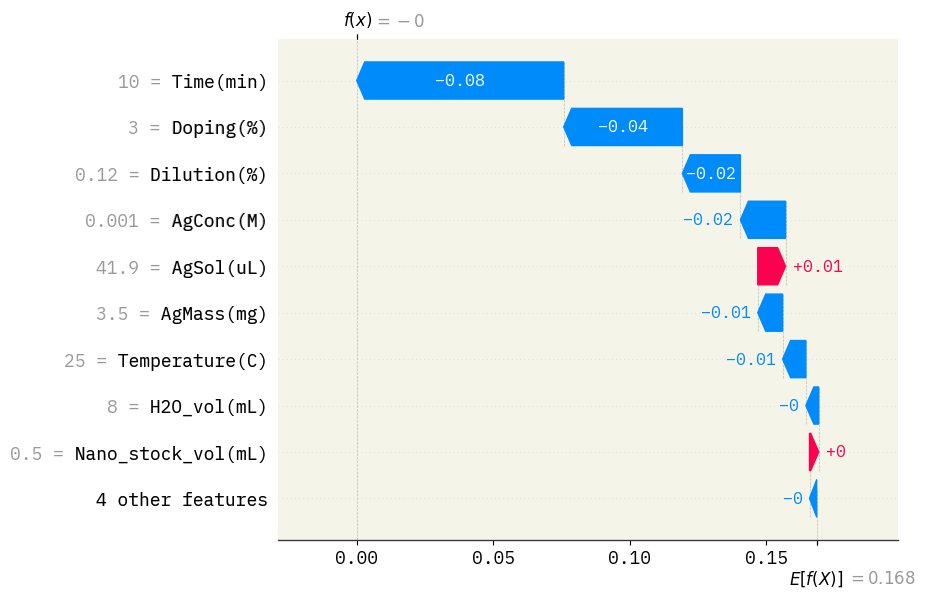

In [240]:
shap.plots.waterfall(low_shap_val[0])

In [244]:
X[54:55], df_2.iloc[54]

(    Dimension1(nm)  Dimension2(nm)  Dilution(%)  Nano_stock_vol(mL)  \
 54         36.9235            7.44         0.29                0.25   
 
     Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  \
 54             1.75      0.006        14.0        9.9854       3.9942   
 
     Doping(%)  AgSol(uL)  Time(min)  Temperature(C)  
 54        2.0       4.78       60.0            50.0  ,
 Dimension1(nm)         36.9235
 Dimension2(nm)            7.44
 Dilution(%)               0.29
 Nano_stock_vol(mL)        0.25
 Diluted_vol(mL)           1.75
 AgConc(M)                0.006
 AgMass(mg)                14.0
 MeOH_vol(mL)            9.9854
 H2O_vol(mL)             3.9942
 Doping(%)                  2.0
 AgSol(uL)                 4.78
 Time(min)                 60.0
 Temperature(C)            50.0
 obj_f                 0.433144
 Name: 54, dtype: object)

In [245]:
large_shap_val = masker_explainer(X[54:55])

Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 5.0 % Ag doping requires 129.2 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reac

  0%|          | 0/156 [00:00<?, ?it/s]

Stock nanoplatelets have dimensions 36.9235 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respec

  8%|▊         | 12/156 [05:14<1:02:56, 26.23s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 35.0 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 0.5 % Ag doping requires 23.1 uL of silver doping solution, respectively. The react

 14%|█▍        | 22/156 [11:12<1:10:10, 31.43s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respec

 21%|██        | 32/156 [16:18<1:04:13, 31.08s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 0.5 % Ag doping requires 6.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 5.0 % Ag doping requires 230.57 uL of silver doping solution, respec

 27%|██▋       | 42/156 [20:41<55:33, 29.24s/it]  

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respec

 33%|███▎      | 52/156 [24:47<47:47, 27.57s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.0 % Ag doping requires 13.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 1.25 % Ag doping requires 4.78 uL of silver doping solution, respectively. The rea

 40%|███▉      | 62/156 [30:05<45:27, 29.02s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respecti

 46%|████▌     | 72/156 [35:49<43:01, 30.73s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reac

 53%|█████▎    | 82/156 [40:28<36:49, 29.85s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 0.25 % Ag doping requires 0.51 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 1.25 % Ag doping requires 1.2 uL of silver doping solution, r

 59%|█████▉    | 92/156 [46:44<34:24, 32.25s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 8.0 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectiv

 65%|██████▌   | 102/156 [51:29<28:00, 31.12s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 8.0954 nm and the optical density of 100x hexanes dilution of stock is 0.31% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 13.372 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 1.75 % Ag doping requires 21.0 uL of silver doping solution, res

 72%|███████▏  | 112/156 [56:46<22:56, 31.28s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 12.0 uL of silver doping solution, respectively. The 

 78%|███████▊  | 122/156 [1:02:42<18:28, 32.60s/it]

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reac

 85%|████████▍ | 132/156 [1:08:26<13:15, 33.15s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respec

 91%|█████████ | 142/156 [1:12:25<07:04, 30.35s/it]

Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectivel

 97%|█████████▋| 152/156 [1:16:46<01:56, 29.07s/it]

Stock nanoplatelets have dimensions 31.121 nm by 7.358 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 3.9942 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.0 % Ag doping requires 4.78 uL of silver doping solution, respectively

PartitionExplainer explainer: 2it [1:21:12, 4872.02s/it]           


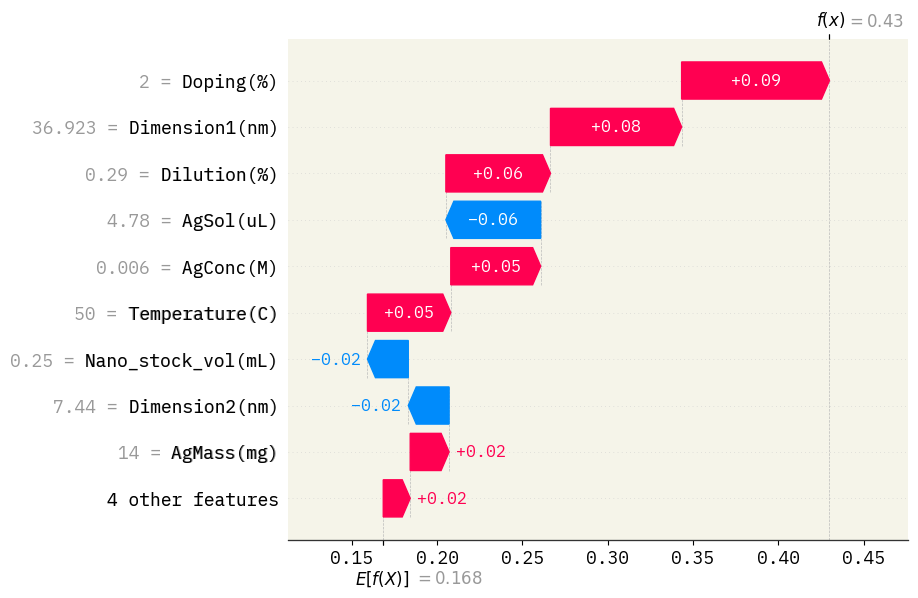

In [246]:
shap.plots.waterfall(large_shap_val[0])

In [250]:
X[51:52], df_2.iloc[51]

(    Dimension1(nm)  Dimension2(nm)  Dilution(%)  Nano_stock_vol(mL)  \
 51         36.9235          7.4427         0.12                 0.5   
 
     Diluted_vol(mL)  AgConc(M)  AgMass(mg)  MeOH_vol(mL)  H2O_vol(mL)  \
 51              3.5    0.00668         7.8           5.0          2.0   
 
     Doping(%)  AgSol(uL)  Time(min)  Temperature(C)  
 51        2.5       4.61       60.0            25.0  ,
 Dimension1(nm)         36.9235
 Dimension2(nm)          7.4427
 Dilution(%)               0.12
 Nano_stock_vol(mL)         0.5
 Diluted_vol(mL)            3.5
 AgConc(M)              0.00668
 AgMass(mg)                 7.8
 MeOH_vol(mL)                 5
 H2O_vol(mL)                  2
 Doping(%)                  2.5
 AgSol(uL)                 4.61
 Time(min)                   60
 Temperature(C)              25
 obj_f                 0.565383
 Name: 51, dtype: object)

In [251]:
largest_shap_val = masker_explainer(X[51:52])

Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 45.77 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 41.1 uL of silver doping solution, respectively. The react

  0%|          | 0/156 [00:00<?, ?it/s]

Stock nanoplatelets have dimensions 18.8 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The 

  8%|▊         | 12/156 [05:21<1:04:15, 26.77s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The rea

 14%|█▍        | 22/156 [10:32<1:05:07, 29.16s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reac

 21%|██        | 32/156 [14:55<57:37, 27.88s/it]  

Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The 

 27%|██▋       | 42/156 [19:14<51:31, 27.12s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The 

 33%|███▎      | 52/156 [23:31<46:10, 26.64s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The 

 40%|███▉      | 62/156 [29:15<45:46, 29.22s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 0.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.29 nm and the optical density of 100x hexanes dilution of stock is 0.26% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The rea

 46%|████▌     | 72/156 [33:33<39:21, 28.12s/it]

Stock nanoplatelets have dimensions 31.121 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.212% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 3.4 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The reac

 53%|█████▎    | 82/156 [38:14<34:39, 28.11s/it]

Stock nanoplatelets have dimensions 35.0 nm by 15.0 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 5.0 % Ag doping requires 230.57 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The react

 59%|█████▉    | 92/156 [42:49<29:48, 27.94s/it]

Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 1.0 % Ag doping requires 25.84 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.27 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 8.0 mL of water. 3.0 % Ag doping requires 41.9 uL of silver doping solution, respectively. The rea

 65%|██████▌   | 102/156 [48:16<26:26, 29.38s/it]

Stock nanoplatelets have dimensions 31.63 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 5.0 mL of MeOH and 4.0 mL of water. 0.5 % Ag doping requires 1.5 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 18.8 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 20.0 mL of MeOH and 2.0 mL of water. 3.0 % Ag doping requires 36.0 uL of silver doping solution, respectively. The react

 72%|███████▏  | 112/156 [52:54<21:11, 28.91s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 50.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 8.737 nm and the optical density of 100x hexanes dilution of stock is 0.42% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reac

 78%|███████▊  | 122/156 [56:51<15:29, 27.34s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 13.8 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reac

 85%|████████▍ | 132/156 [1:00:33<10:18, 25.77s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 14.04 nm and the optical density of 100x hexanes dilution of stock is 0.175% recorded at 512nm. 0.25 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 0.75 % Ag doping requires 9.0 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 6.52 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.0007 M is made with 3.5 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 10.0 % Ag doping requires 97.7 uL of silver doping solution, respectively. The

 91%|█████████ | 142/156 [1:04:13<05:45, 24.65s/it]

Stock nanoplatelets have dimensions 46.3494 nm by 8.0954 nm and the optical density of 100x hexanes dilution of stock is 0.31% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 180.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.44 nm and the optical density of 100x hexanes dilution of stock is 0.29% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 1.75 mL for each trial of doping. Silver acetate solution of 0.006 M is made with 14.0 mg of silver acetate in 9.9854 mL of MeOH and 3.9942 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respec

 97%|█████████▋| 152/156 [1:06:40<01:26, 21.63s/it]

Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 2.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 60.0 minutes at 25.0 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
Stock nanoplatelets have dimensions 36.9235 nm by 7.4427 nm and the optical density of 100x hexanes dilution of stock is 0.12% recorded at 512nm. 0.5 mL nanoplatelets stock is diluted 7x by hexanes using 3.5 mL for each trial of doping. Silver acetate solution of 0.00668 M is made with 7.8 mg of silver acetate in 5.0 mL of MeOH and 8.0 mL of water. 2.5 % Ag doping requires 4.61 uL of silver doping solution, respectively. Th

PartitionExplainer explainer: 2it [1:11:14, 4274.50s/it]           


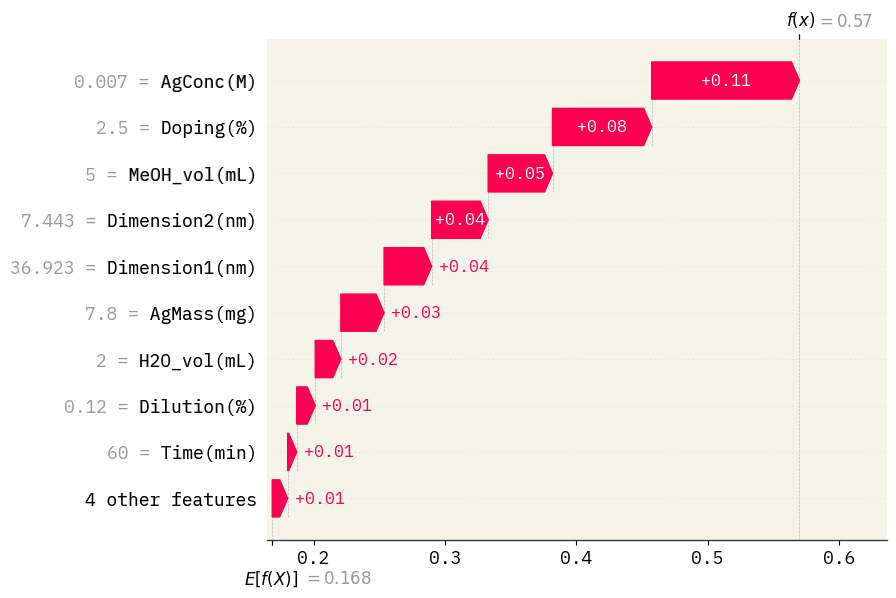

In [252]:
shap.plots.waterfall(largest_shap_val[0])

## LOOCV For BOLIFT with gpt-4o and gpt-3.5 Instruct

100%|██████████| 50/50 [30:57<00:00, 37.14s/it]  

|        predicted        |   label    |     AE     | 
|    0.14   +/-   0.11    |    0.31    |    0.17    |
|    0.13   +/-   0.08    |    0.23    |    0.10    |
|    0.15   +/-   0.03    |    0.23    |    0.09    |
|    0.33   +/-   0.07    |    0.08    |    0.25    |
|    0.06   +/-   0.03    |    0.00    |    0.06    |
|    0.03   +/-   0.01    |    0.09    |    0.06    |
|    0.07   +/-   0.11    |    0.10    |    0.03    |
|    0.15   +/-   0.08    |    0.09    |    0.06    |
|    0.08   +/-   0.07    |    0.09    |    0.01    |
|    0.11   +/-   0.01    |    0.12    |    0.02    |
|    0.11   +/-   0.06    |    0.11    |    0.00    |
|    0.15   +/-   0.02    |    0.10    |    0.04    |
|    0.17   +/-   0.08    |    0.10    |    0.07    |
|    0.06   +/-   0.02    |    0.13    |    0.07    |
|    0.10   +/-   0.01    |    0.12    |    0.02    |
|    0.07   +/-   0.03    |    0.17    |    0.10    |
|    0.26   +/-   0.05    |    0.14    |    0.12    |
|    0.16   +/-   0.08    |

Text(0.5, 1.0, 'f = QY * AUC2')

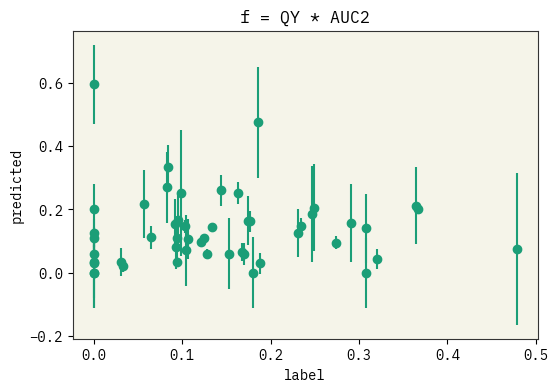

In [269]:
#lets make a LOOCV for the asktell model for the first 50 points

indexes = np.arange(50)
# np.random.shuffle(indexes)
yhat = []
# y_conf = []
y = []
df_for_cv = df_2.iloc[indexes]
prompts = []
labels_f = []
for i, r in df_for_cv.iterrows():
    s = r.drop('obj_f')
    prompts.append(make_prompt_from_features(s))
    labels_f.append(r['obj_f'])

for i in tqdm.tqdm(range(50)):
    train_p = prompts[:i] + prompts[i+1:]
    train_l = labels_f[:i] + labels_f[i+1:]
    test_p = prompts[i]
    test_l = labels_f[i]
    # print(train_p, train_l, test_p, test_l)
    asktell = bolift.AskTellFewShotTopk(
        prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
            " Each answer should be numeric and ends with ###." \
            " Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-3.5-turbo-instruct",
        selector_k=5,
        temperature=0.7
    )
    for i,(p,l) in enumerate(zip(train_p, train_l)):
        # p = make_prompt_from_features(train.iloc[i].drop('obj_f'))
        asktell.tell(p, float(l))

    # for i in range(len(test_p)):
    yhat.append(asktell.predict(test_p))
    y.append(test_l)

#make a plot of the results
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
    n+=1
    mae = abs(ihat.mean()-i)
    print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
    sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
# plt.plot((0,0.2), (0,0.2), '--')



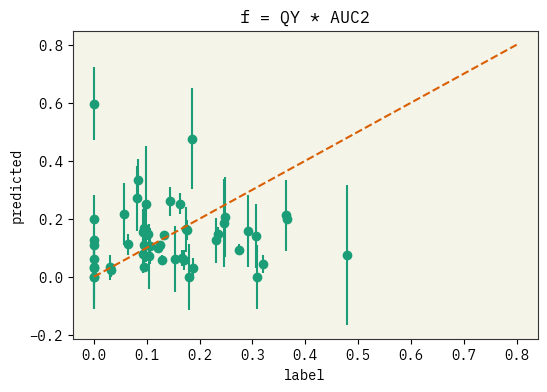

In [270]:
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
plt.plot((0,0.8), (0,0.8), '--')

In [266]:
asktell.predict(test_p)

DiscreteDist([0.01 0.05 0.08], [0.2 0.2 0.6])

In [7]:
import numpy as np
import tqdm
import bolift
indexes = np.arange(50)
# np.random.shuffle(indexes)
yhat = []
# y_conf = []
y = []
df_for_cv = df_2.iloc[indexes]
prompts = []
labels_f = []
for i, r in df_for_cv.iterrows():
    s = r.drop('obj_f')
    prompts.append(make_prompt_from_features(s))
    labels_f.append(r['obj_f'])

for i in tqdm.tqdm(range(50)):
    train_p = prompts[:i] + prompts[i+1:]
    train_l = labels_f[:i] + labels_f[i+1:]
    test_p = prompts[i]
    test_l = labels_f[i]
    # print(train_p, train_l, test_p, test_l)
    asktell = bolift.AskTellFewShotTopk(
        # prefix="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
        #     " Each answer should be numeric and ends with ###." \
        #     " Use the following information to complete the prompt: \n",
        x_formatter=lambda x: f"the experimental procedure: {x}",
        y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
        y_formatter=lambda y: f"{y:.2f}",
        model="gpt-4o",
        selector_k=5,
        temperature=0.7
    )
    for i,(p,l) in enumerate(zip(train_p, train_l)):
        # p = make_prompt_from_features(train.iloc[i].drop('obj_f'))
        asktell.tell(p, float(l))

    # for i in range(len(test_p)):
    yhat.append(asktell.predict(test_p,system_message="Complete with the objective function which is the product between the Quantum Yield and relative secondary area under the curve with peak at 650 nm."\
            " Each answer should be numeric and ends with ###." \
            " Use the following information to complete the prompt: \n"))
    y.append(test_l)

#make a plot of the results
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
    n+=1
    mae = abs(ihat.mean()-i)
    print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
    sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
# plt.plot((0,0.2), (0,0.2), '--')

100%|██████████| 50/50 [31:22<00:00, 37.66s/it]

|        predicted        |   label    |     AE     | 
|    0.08   +/-   0.04    |    0.31    |    0.23    |
|    0.23   +/-   0.04    |    0.23    |    0.00    |
|    0.15   +/-   0.11    |    0.23    |    0.08    |
|    0.11   +/-   0.05    |    0.08    |    0.03    |
|    0.08   +/-   0.11    |    0.00    |    0.08    |
|    0.09   +/-   0.01    |    0.09    |    0.00    |
|    0.07   +/-   0.01    |    0.10    |    0.03    |
|    0.09   +/-   0.01    |    0.09    |    0.01    |
|    0.10   +/-   0.11    |    0.09    |    0.01    |
|    0.10   +/-   0.11    |    0.12    |    0.02    |
|    0.15   +/-   0.00    |    0.11    |    0.04    |
|    0.11   +/-   0.11    |    0.10    |    0.01    |
|    0.15   +/-   0.11    |    0.10    |    0.05    |
|    0.10   +/-   0.00    |    0.13    |    0.03    |
|    0.15   +/-   0.11    |    0.12    |    0.03    |
|    0.13   +/-   0.02    |    0.17    |    0.04    |
|    0.15   +/-   0.00    |    0.14    |    0.01    |
|    0.17   +/-   0.01    |

ModuleNotFoundError: No module named 'matplotlib'

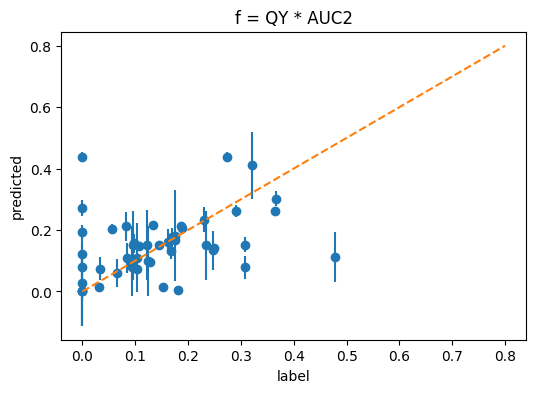

In [11]:
import matplotlib.pyplot as plt
y_plot    = np.array(y)[np.where(np.array(y) >= 0)]
yhat_plot = np.array([ihat.mean() for ihat in yhat])[np.where(np.array(y) >= 0)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(y) >= 0)]
plt.figure(figsize=(6, 4))
plt.xlabel('label')
plt.ylabel('predicted')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('f = QY * AUC2')
plt.plot((0,0.8), (0,0.8), '--')